# Week 2 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. 

This week, we ask you to build a corpus for preliminary analysis and articulate what your sample represents in context of your final project. We begin by exploring how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 
<200 words

For my final project, I would like to analyze Use of Force policies used by Police Departments across the United States. In recent years, increasing amounts of attention has been paid to policing policies, tactics, and accountability. This is the result, partially, of numerous incidents (many caught on videos that went viral) of police officers using excessive force, often against black and brown men. As the conversation has turned to how police officers can be held accountable and be better trained, researchers and activists have turned to Use of Force policies utilized by Police Departments to understand the rules that govern how much force an officer might use, in what types of situations.

## ***Why?***
<200 words

There is some existing research that suggests more restrictive Use of Force policies result in more restrained police tactics, focusing on de-escalation and non-lethal uses of force (e.g. taser) instead of guns, and can decrease police-involved shootings and homicides. While relating the results of my analysis to nationwide homicide / police-involved shooting data might be out of the scope of this project, a systematic analysis of Use of Force policies may still prove beneficial in understanding the following:
- is there even variation in how restrictive or strict Use of Force policies are?
- if there is variation, what form does this take? Which rules are shared more broadly and which rules vary a lot?
- what can this reveal about different attitudes towards human life in different police departments?
- what could this reveal about best practices for police departments to adopt?

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

My sample is Use of Force policies from the 100 largest Police Departments in the United States. This is primarily due to my source of data, which is coming from the [Use of Force Project Database](http://useofforceproject.org/database). A group of activists FOIA'd the largest police departments and have compiled this database of policies. Ideally, I would not like to restrict my sample any further than this - given that each policy is about 20-30 pages, I don't think ~300 pages of text is too large and I would like to include as much as possible in my analysis.

Of course, the United States has many more than 100 police departments, so my sample design is already restricted because I will not have the ability or time to FOIA all the other departments. 

The social game and actors about whom I am seeking to make inferences are police officers and police departments. These policies can play a large role in determining police department culture and police officer training, which in turn plays a large role in how police officers act in the field. Analyzing this text can therefore be hugely important to my research question. 

That said, a bureaucratic guideline and policy could still be very removed from a police officer's reality. Simply because a policy insists on de-escalation does not necessarily mean the training emphasizes it, especially if a police department is strapped for cash and does not adequately train its officers. A limitation of this analysis, therefore, is that Use of Force policies may not be very predictive of actual police behavior.

For this reason, a reasonable path to scale up my sample would be:
- getting Use of Force policies from ALL departments, not just the top 100
- getting access to other police training materials / other data that proxies for how police officers are trained
- analyzing data on police involved shootings and police behavior more generally. The Use of Force Project begins to do this and if time permits I would like build on this analysis

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [2]:
%%html
<img source="loopdesign.png">

[Click here for loop design](loopdesign.png)

In [66]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [67]:
type(x)

numpy.ndarray

Interrogate the AnnotationsContainer object.

In [68]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [69]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [70]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [71]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


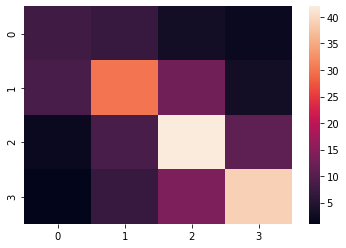

In [72]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [73]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [74]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [75]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [76]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [77]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


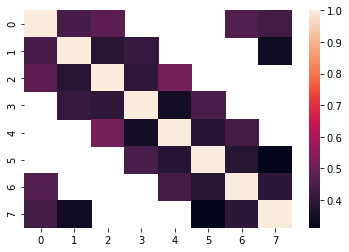

In [78]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [79]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [80]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [81]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

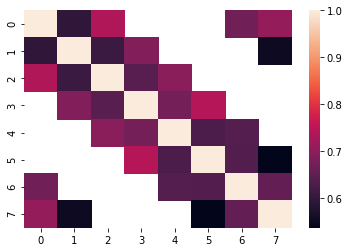

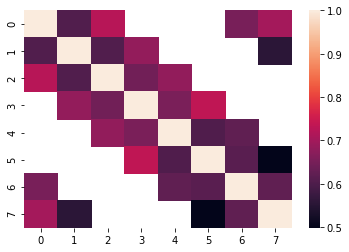

In [82]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [83]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [84]:
#x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
#anno = AnnotationsContainer.from_array(x, missing_values=[-1])

mturk_data = pandas.read_csv("Batch_4000156_batch_results.csv")

In [85]:
mturk_data.head()

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,WorkTimeInSeconds,LifetimeApprovalRate,Last30DaysApprovalRate,Last7DaysApprovalRate,Input.document_url,Answer.use_of_force1.ban_chokehold,Answer.use_of_force2.require_warning,Answer.use_of_force3.no_shooting_moving,Approve,Reject
0,3ICOHX7ENBAEKWMKL74NMLAZJN10EW,3SBFCXF7YBJ8PBYVJ0RB4AZ4GT14W4,Do the following rules appear in the police de...,Check which of these rules appear in the given...,"document, classification",$2.00,Sat Apr 18 23:07:02 PDT 2020,3,BatchId:4000156;OriginalHitTemplateId:928390860;,7200,...,273,0% (0/0),0% (0/0),0% (0/0),https://static1.squarespace.com/static/5699615...,False,True,False,NaN,NaN
1,3ICOHX7ENBAEKWMKL74NMLAZJN10EW,3SBFCXF7YBJ8PBYVJ0RB4AZ4GT14W4,Do the following rules appear in the police de...,Check which of these rules appear in the given...,"document, classification",$2.00,Sat Apr 18 23:07:02 PDT 2020,3,BatchId:4000156;OriginalHitTemplateId:928390860;,7200,...,639,0% (0/0),0% (0/0),0% (0/0),https://static1.squarespace.com/static/5699615...,False,False,True,NaN,NaN
2,3ICOHX7ENBAEKWMKL74NMLAZJN10EW,3SBFCXF7YBJ8PBYVJ0RB4AZ4GT14W4,Do the following rules appear in the police de...,Check which of these rules appear in the given...,"document, classification",$2.00,Sat Apr 18 23:07:02 PDT 2020,3,BatchId:4000156;OriginalHitTemplateId:928390860;,7200,...,1456,0% (0/0),0% (0/0),0% (0/0),https://static1.squarespace.com/static/5699615...,False,True,True,NaN,NaN
3,3FBEFUUYRJ468URN7RIIZ3UZBBPA6C,3SBFCXF7YBJ8PBYVJ0RB4AZ4GT14W4,Do the following rules appear in the police de...,Check which of these rules appear in the given...,"document, classification",$2.00,Sat Apr 18 23:07:02 PDT 2020,3,BatchId:4000156;OriginalHitTemplateId:928390860;,7200,...,2534,0% (0/0),0% (0/0),0% (0/0),https://static1.squarespace.com/static/5699615...,False,True,True,NaN,NaN
4,3FBEFUUYRJ468URN7RIIZ3UZBBPA6C,3SBFCXF7YBJ8PBYVJ0RB4AZ4GT14W4,Do the following rules appear in the police de...,Check which of these rules appear in the given...,"document, classification",$2.00,Sat Apr 18 23:07:02 PDT 2020,3,BatchId:4000156;OriginalHitTemplateId:928390860;,7200,...,257,0% (0/0),0% (0/0),0% (0/0),https://static1.squarespace.com/static/5699615...,False,False,True,NaN,NaN


In [86]:
mturk_data.shape

(18, 33)

In [87]:
mturk_data = mturk_data[['WorkerId',
                         'HITId',
                         'Answer.use_of_force1.ban_chokehold',
                         'Answer.use_of_force2.require_warning',
                         'Answer.use_of_force3.no_shooting_moving']]

In [88]:
mturk_data

,WorkerId,HITId,Answer.use_of_force1.ban_chokehold,Answer.use_of_force2.require_warning,Answer.use_of_force3.no_shooting_moving
0,A12IIUPGGT3J5L,3ICOHX7ENBAEKWMKL74NMLAZJN10EW,False,True,False
1,A1YSYI926BBOHW,3ICOHX7ENBAEKWMKL74NMLAZJN10EW,False,False,True
2,AYKQ1UN34V8KL,3ICOHX7ENBAEKWMKL74NMLAZJN10EW,False,True,True
3,A2F2DDH12YU4AK,3FBEFUUYRJ468URN7RIIZ3UZBBPA6C,False,True,True
4,A1YSYI926BBOHW,3FBEFUUYRJ468URN7RIIZ3UZBBPA6C,False,False,True
5,AQ3KPKZ6UIYPF,3FBEFUUYRJ468URN7RIIZ3UZBBPA6C,True,True,True
6,A25F6WT9CIM0Z5,3BAWBGQGYKY94I8Q1WE61488RW9V7W,True,True,True
7,A1YSYI926BBOHW,3BAWBGQGYKY94I8Q1WE61488RW9V7W,False,False,False
8,A31681CCEVDIH3,3BAWBGQGYKY94I8Q1WE61488RW9V7W,False,True,True
9,AOV6272WT2T1N,3YD0MU1NC10PCU5SQ1NA5HUV6M9A7B,True,False,True


In [89]:
mturk_data_long = pandas.melt(mturk_data,id_vars=['HITId','WorkerId'],var_name='criteria',value_name="Answer.use_of_force")

In [90]:
mturk_data_long =  mturk_data_long.replace(False,0)
mturk_data_long =  mturk_data_long.replace(True,1)

In [91]:
mturk_data_long.head()

,HITId,WorkerId,criteria,Answer.use_of_force
0,3ICOHX7ENBAEKWMKL74NMLAZJN10EW,A12IIUPGGT3J5L,Answer.use_of_force1.ban_chokehold,0.0
1,3ICOHX7ENBAEKWMKL74NMLAZJN10EW,A1YSYI926BBOHW,Answer.use_of_force1.ban_chokehold,0.0
2,3ICOHX7ENBAEKWMKL74NMLAZJN10EW,AYKQ1UN34V8KL,Answer.use_of_force1.ban_chokehold,0.0
3,3FBEFUUYRJ468URN7RIIZ3UZBBPA6C,A2F2DDH12YU4AK,Answer.use_of_force1.ban_chokehold,0.0
4,3FBEFUUYRJ468URN7RIIZ3UZBBPA6C,A1YSYI926BBOHW,Answer.use_of_force1.ban_chokehold,0.0


In [92]:
mturk_data_long = mturk_data_long.set_index(['HITId','criteria','WorkerId'])
stacked = mturk_data_long.stack()

In [93]:
mturk_unstacked = stacked.unstack(2)

In [94]:
mturk_unstacked.columns

Index(['A122UC2R9WJK0C', 'A12IIUPGGT3J5L', 'A1EFWFEGH5HUS8', 'A1M24593XO5Z3C',
       'A1YSYI926BBOHW', 'A25F6WT9CIM0Z5', 'A282NN2RO8XZP6', 'A2F2DDH12YU4AK',
       'A2VRDE2FHCBMF8', 'A30KYQGABO7JER', 'A31681CCEVDIH3', 'A3T0EL0S43B30Q',
       'A82Q1HS5CPZ5I', 'AOV6272WT2T1N', 'AQ3KPKZ6UIYPF', 'AYKQ1UN34V8KL'],
      dtype='object', name='WorkerId')

In [95]:
# get array for pyanno
mturk_unstacked.reset_index(drop=True, inplace=True)

In [96]:
mturk_unstacked.head()

WorkerId,A122UC2R9WJK0C,A12IIUPGGT3J5L,A1EFWFEGH5HUS8,A1M24593XO5Z3C,A1YSYI926BBOHW,A25F6WT9CIM0Z5,A282NN2RO8XZP6,A2F2DDH12YU4AK,A2VRDE2FHCBMF8,A30KYQGABO7JER,A31681CCEVDIH3,A3T0EL0S43B30Q,A82Q1HS5CPZ5I,AOV6272WT2T1N,AQ3KPKZ6UIYPF,AYKQ1UN34V8KL
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [97]:
# Want to make a dictionary of which coders should be "grouped" together - i.e. coded the same document
group = 0
#dict1 = {'group':[],'coders':[]}
dict1 = {}
row_start = 0
for doc in range(6):
    row_end = row_start + 3
    data = mturk_unstacked.iloc[row_start:row_end]
    #print(row_start,row_end)
    for k in range(len(mturk_unstacked.columns)):
        #print(k)
        if not data.iloc[:,k].isnull().values.any():
            if str(group) not in dict1:
                dict1[str(group)] = [k]
            else:
                dict1[str(group)].append(k)
    #print(row_start,row_end)
    row_start = row_end
    group += 1

In [98]:
# Groups of coders that coded together
dict1

{'0': [6, 8, 12],
 '1': [4, 5, 10],
 '2': [4, 7, 14],
 '3': [1, 4, 15],
 '4': [3, 9, 11],
 '5': [0, 2, 13]}

In [99]:
# turn into numpy array
mturk_unstacked = mturk_unstacked.fillna(-1)
mturk_unstacked = np.array(mturk_unstacked)

In [100]:
type(mturk_unstacked)

numpy.ndarray

In [101]:
# turn into annotations
anno_d = AnnotationsContainer.from_array(mturk_unstacked, missing_values=[-1])

In [102]:
anno_d.annotations[:10]

array([[-1, -1, -1, -1, -1, -1,  0, -1,  0, -1, -1, -1,  0, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1,  0, -1,  0, -1, -1, -1,  0, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1,  1, -1,  0, -1, -1, -1,  1, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1,  1, -1],
       [-1, -1, -1, -1,  0, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1],
       [-1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1],
       [-1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0]])

In [103]:
anno_d.labels

[0.0, 1.0]

In [104]:
anno_d.missing_values

[-1]

Now that the annotations are ready to be analyzed, we discuss inter-coder variation. We start by looking at label frequency

In [105]:
pyanno.measures.agreement.labels_frequency(anno_d.annotations,2)

array([0.55555556, 0.44444444])

From the above, it appears that both labels (true and false) are chosen roughly equally, with false being chosen a little bit more frequently

[[2. 0.]
 [1. 0.]]


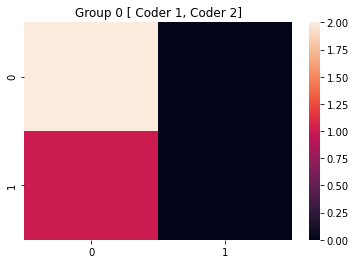

[[2. 0.]
 [0. 1.]]


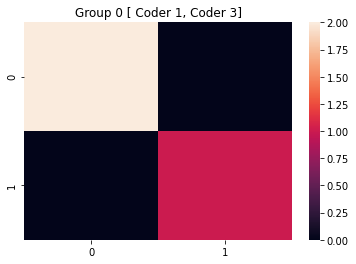

[[2. 1.]
 [0. 0.]]


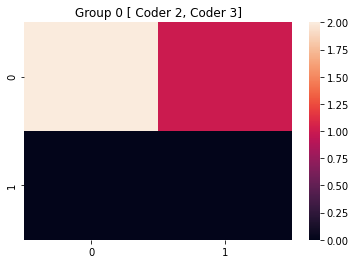

[[0. 3.]
 [0. 0.]]


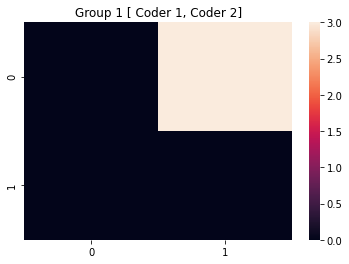

[[1. 2.]
 [0. 0.]]


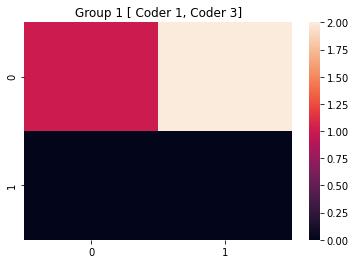

[[0. 0.]
 [1. 2.]]


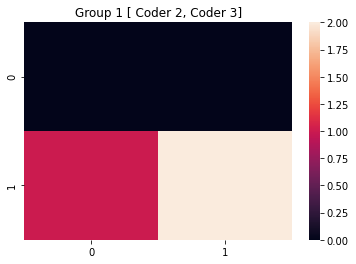

[[1. 1.]
 [0. 1.]]


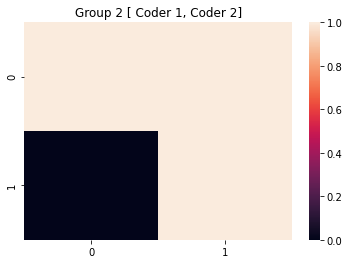

[[0. 2.]
 [0. 1.]]


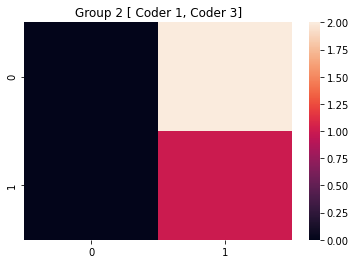

[[0. 1.]
 [0. 2.]]


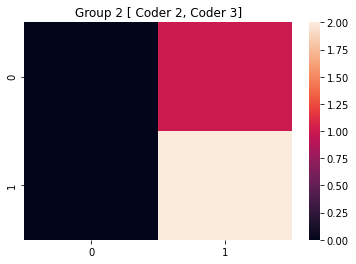

[[1. 1.]
 [1. 0.]]


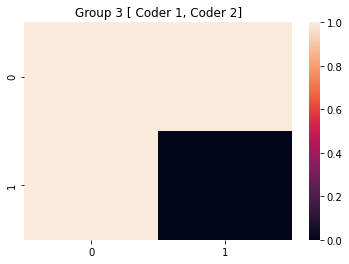

[[1. 1.]
 [0. 1.]]


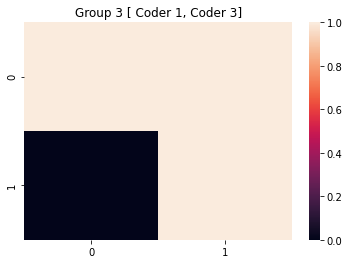

[[1. 1.]
 [0. 1.]]


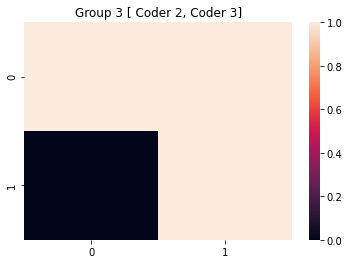

[[0. 1.]
 [0. 2.]]


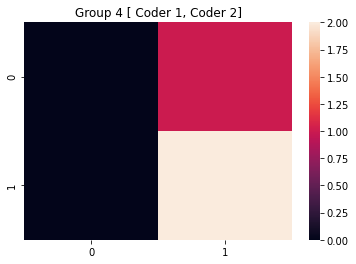

[[1. 0.]
 [2. 0.]]


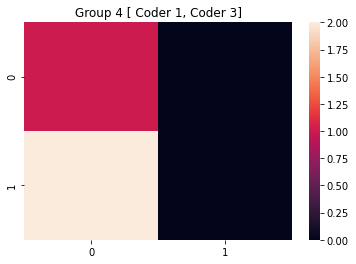

[[0. 0.]
 [3. 0.]]


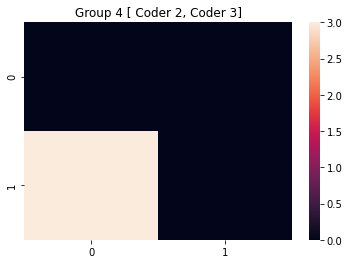

[[3. 0.]
 [0. 0.]]


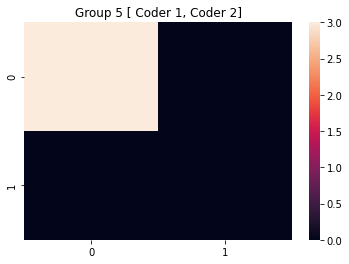

[[1. 2.]
 [0. 0.]]


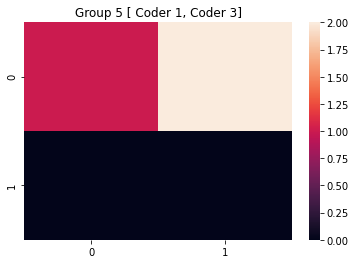

[[1. 2.]
 [0. 0.]]


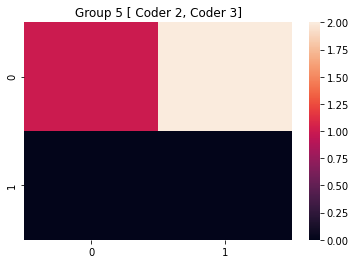

In [106]:
# For each of the six documents, want to pairwise want to compare 2 coders to each other
for i in range(len(dict1)):
    coder1 = dict1[str(i)][0]
    coder2 = dict1[str(i)][1]
    coder3 = dict1[str(i)][2]
    
    c = pyanno.measures.agreement.confusion_matrix(anno_d.annotations[:,coder1], anno_d.annotations[:,coder2],2)
    print(c)
    ac = seaborn.heatmap(c)
    plt.title('Group {} [ Coder 1, Coder 2]'.format(i))
    plt.show()
    
    c = pyanno.measures.agreement.confusion_matrix(anno_d.annotations[:,coder1], anno_d.annotations[:,coder3],2)
    print(c)
    ac = seaborn.heatmap(c)
    plt.title('Group {} [ Coder 1, Coder 3]'.format(i))
    plt.show()
    
    c = pyanno.measures.agreement.confusion_matrix(anno_d.annotations[:,coder2], anno_d.annotations[:,coder3],2)
    print(c)
    ac = seaborn.heatmap(c)
    plt.title('Group {} [ Coder 2, Coder 3]'.format(i))
    plt.show()
    
    
    
    


Above, we have 3 plots for each document. Since each document had 3 coders, the plots represent 1) comparing coder 1 to coder 2; 2) comparing coder 1 to coder 3; 3) comparing coder 2 to coder 3.

There are definitely some documents that seem to have more agreement than others. For example, the coders agree pretty well for document 1 (group 0). Coder 1 and Coder 3 are actually exactly in agreement.

For Group 3 (document 4) on the other hand, it's hard to see if we can trust the coded annotations since no pairs of coders seem perfectly aligned



Next, I calculate four different metrics of agreement: Scott's pi, Fleiss Kappa, Krippendorffs (though in my case, disagreeing on "true" is not better or worse than disagreeing on "false") and Cohen's Kappa

In [107]:
# Scott's Pi
for i in range(len(dict1)):
    coder1 = dict1[str(i)][0]
    coder2 = dict1[str(i)][1]
    coder3 = dict1[str(i)][2]
    scotts_pi_1_2 = scotts_pi(anno_d.annotations[:,coder1], anno_d.annotations[:,coder2])
    print('Scotts pi for Group {}, Coder 1 and Coder 2, is {}'.format(i,scotts_pi_1_2))
    
    scotts_pi_1_3 = scotts_pi(anno_d.annotations[:,coder1], anno_d.annotations[:,coder3])                      
    print('Scotts pi for Group {}, Coder 1 and Coder 3, is {}'.format(i,scotts_pi_1_3)) 

    scotts_pi_2_3 = scotts_pi(anno_d.annotations[:,coder2], anno_d.annotations[:,coder3])                      
    print('Scotts pi for Group {}, Coder 2 and Coder 3, is {}'.format(i,scotts_pi_2_3)) 

Scotts pi for Group 0, Coder 1 and Coder 2, is -0.20000000000000057
Scotts pi for Group 0, Coder 1 and Coder 3, is 1.0
Scotts pi for Group 0, Coder 2 and Coder 3, is -0.20000000000000057
Scotts pi for Group 1, Coder 1 and Coder 2, is -1.0571428571428574
Scotts pi for Group 1, Coder 1 and Coder 3, is -0.5000000000000001
Scotts pi for Group 1, Coder 2 and Coder 3, is -0.20000000000000057
Scotts pi for Group 2, Coder 1 and Coder 2, is 0.24999999999999986
Scotts pi for Group 2, Coder 1 and Coder 3, is -0.37142857142857166
Scotts pi for Group 2, Coder 2 and Coder 3, is -0.20000000000000057
Scotts pi for Group 3, Coder 1 and Coder 2, is -0.7777777777777778
Scotts pi for Group 3, Coder 1 and Coder 3, is 0.33333333333333326
Scotts pi for Group 3, Coder 2 and Coder 3, is 0.24999999999999986
Scotts pi for Group 4, Coder 1 and Coder 2, is -0.20000000000000057
Scotts pi for Group 4, Coder 1 and Coder 3, is -0.5000000000000001
Scotts pi for Group 4, Coder 2 and Coder 3, is -1.0
Scotts pi for Group 

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


In [108]:
# cohen's kappa
for i in range(len(dict1)):
    coder1 = dict1[str(i)][0]
    coder2 = dict1[str(i)][1]
    coder3 = dict1[str(i)][2]
    p_1_2 = cohens_kappa(anno_d.annotations[:,coder1], anno_d.annotations[:,coder2])
    print('Cohens kappa for Group {}, Coder 1 and Coder 2, is {}'.format(i,p_1_2))
    
    p_1_3 = cohens_kappa(anno_d.annotations[:,coder1], anno_d.annotations[:,coder3])                      
    print('Cohens kappa for Group {}, Coder 1 and Coder 3, is {}'.format(i,p_1_3)) 

    p_2_3 = cohens_kappa(anno_d.annotations[:,coder2], anno_d.annotations[:,coder3])                      
    print('Cohens kappa for Group {}, Coder 2 and Coder 3, is {}'.format(i,p_2_3)) 


Cohens kappa for Group 0, Coder 1 and Coder 2, is 0.0
Cohens kappa for Group 0, Coder 1 and Coder 3, is 1.0
Cohens kappa for Group 0, Coder 2 and Coder 3, is 0.0
Cohens kappa for Group 1, Coder 1 and Coder 2, is -0.2857142857142857
Cohens kappa for Group 1, Coder 1 and Coder 3, is -0.125
Cohens kappa for Group 1, Coder 2 and Coder 3, is 0.0
Cohens kappa for Group 2, Coder 1 and Coder 2, is 0.4375
Cohens kappa for Group 2, Coder 1 and Coder 3, is 0.14285714285714285
Cohens kappa for Group 2, Coder 2 and Coder 3, is 0.0
Cohens kappa for Group 3, Coder 1 and Coder 2, is -0.6363636363636362
Cohens kappa for Group 3, Coder 1 and Coder 3, is 0.39999999999999997
Cohens kappa for Group 3, Coder 2 and Coder 3, is 0.4375
Cohens kappa for Group 4, Coder 1 and Coder 2, is 0.0
Cohens kappa for Group 4, Coder 1 and Coder 3, is 0.0
Cohens kappa for Group 4, Coder 2 and Coder 3, is 0.0
Cohens kappa for Group 5, Coder 1 and Coder 2, is nan
Cohens kappa for Group 5, Coder 1 and Coder 3, is 0.0
Cohens ka

In [109]:
# Fleiss kappa - n coders
fleiss_kappa(anno_d.annotations[::])

0.025000000000000112

In [110]:
# Krippendorffs alpha - n coders
krippendorffs_alpha(anno_d.annotations[::])

0.043055555555555625

In [112]:
m = pairwise_matrix(cohens_kappa,anno_d.annotations)

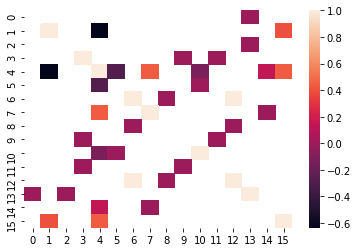

In [113]:
ax = seaborn.heatmap(m)
plt.show()

The above is not very promising, especially Scott's Pi. A negative k means there is little agreement among coders than would be expected by random chance. A large part of this is because for each pair of coders, I only have 3 data points - it is not hard to agree by random chance with 3 observations.

The results from Cohen's K are a bit more promising, since most values are at least above 0. This is also true in the pairwise heatmap above - there isn't much agreement above coders though many of the values are between 0 and 1.

From the above results, it is difficult to distinguish whether this is a small sample problem or whether coding flags in Use of Force policies is not a great a task for human assessment.

Solutions to the small sample problem would be:
- Adding many more flags per document so for each pairwise coder comparison, I have more data points
- Find a way to limit the number of unique coders for my MTurk task. If I had 3 unique coders that coded all 6 documents x 3 flags, I would have had 18 data points for each pair of coders. If I then increased the number of documents and flags, I would have much more data. 

However, I don't think it is possible to limit total number of unique coders on MTurk, and increasing either the number of flags or the data - while still paying a fair wage - gets expensive very quickly

Solutions to the problem of human assessment for Use of Force policies:
- While flagging these guidelines should not be extremely subjective or individualistic, Use of Force policies are very dense, formal, and bureaucratic. For a non-expert to be able to read and understand all the legalese is not an easy task and might suggest that only certain people might be qualified to code up these policies. 
- Alternatively, a more robust training guide could help improve quality of coding. That is, if my assignment had provided many examples of each of the flags, coders may have a better sense of what they're looking for


# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides three relevant models: ModelA, ModelB, and ModelBt. Model A can only be currently run on a balanced 8-coder design, but assesses accuracy purely based on agreement. Model B with $\theta$s models the relationship between each coder and code. Model B is the Dawid & Skene model from the reading. The following image schematically suggests the relationship between the models. <img src="../data/models.png">

The models should provide similar results. To estimate the parameters for any models, we first need to create a new model. 

In [114]:
# create a new instance of model A, with 4 label classes
model = ModelB.create_initial_state(4, 8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.70561273 0.18582387 0.05293868 0.05562471]
  [0.27536674 0.6066934  0.06099869 0.05694117]
  [0.0788205  0.15416028 0.68144665 0.08557257]
  [0.00453134 0.14965043 0.17912012 0.66669811]]

 [[0.77716385 0.08903633 0.07414392 0.0596559 ]
  [0.1208964  0.68787561 0.11693586 0.07429213]
  [0.01508549 0.24662319 0.55971589 0.17857542]
  [0.19823163 0.04896949 0.08165139 0.67114749]]

 [[0.57672891 0.23497101 0.11699019 0.07130989]
  [0.11809079 0.55869182 0.20063433 0.12258306]
  [0.08767458 0.07799237 0.64304111 0.19129193]
  [0.00714567 0.24904744 0.16373892 0.58006797]]

 [[0.64153863 0.20205453 0.08742007 0.06898678]
  [0.2517946  0.51283138 0.15096764 0.08440638]
  [0.05598793 0.0412818  0.80360007 0.0991302 ]
  [0.01885533 0.0955542  0.07382223 0.81176825]]

 [[0.6890165  0.14112089 0.07472474 0.09513787]
  [0.11789447 0.59200987 0.14128507 0.1488106 ]
  [0.23666659 0.09522875 0.57475257 0.09335209]
  [0.01663951 0.01327834 0.23126757 0.73881457]]

 [[0.67181853 0.30158945 0.015

In [115]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator.

In [116]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

In [119]:
model = ModelB.create_initial_state(4, 8)
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [120]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap.

In [121]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

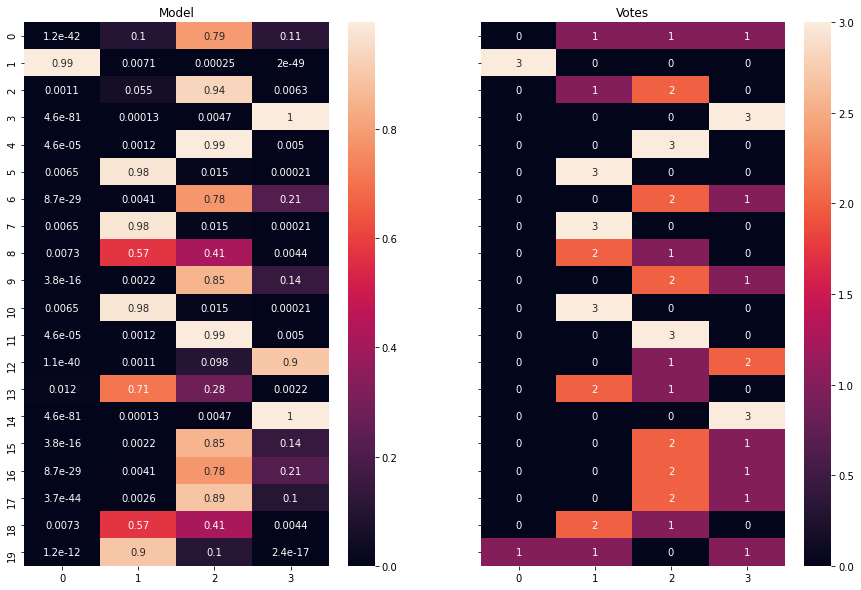

In [122]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

This differs markedly from taking annotator scores at face value (Add comparison of average values)

In [123]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [124]:
print(samples[0].mean(axis=0))
print(samples[0].std(axis=0))

[[[0.72580173 0.20479882 0.04766738 0.02173206]
  [0.1370551  0.70349677 0.09020066 0.06924747]
  [0.02799192 0.15420515 0.68018939 0.13761355]
  [0.01299542 0.03341253 0.104724   0.84886806]]

 [[0.66227919 0.21217484 0.09693862 0.02860735]
  [0.13078088 0.70002322 0.11734953 0.05184636]
  [0.03446956 0.16942804 0.66280813 0.13329427]
  [0.01118977 0.06600932 0.13205561 0.7907453 ]]

 [[0.79786941 0.13478394 0.04722392 0.02012273]
  [0.09792983 0.76069556 0.1013078  0.04006681]
  [0.06605833 0.13590908 0.69302587 0.10500671]
  [0.01659914 0.05941863 0.21770058 0.70628165]]

 [[0.65643378 0.27164762 0.05218605 0.01973255]
  [0.10528104 0.73065212 0.11847375 0.04559308]
  [0.0273995  0.15512111 0.66902714 0.14845226]
  [0.00859797 0.03879115 0.24295478 0.7096561 ]]

 [[0.76482459 0.13203123 0.08253914 0.02060505]
  [0.12601886 0.67617195 0.1530722  0.04473699]
  [0.02176656 0.21508289 0.63737413 0.12577641]
  [0.00832025 0.07036186 0.18930654 0.73201135]]

 [[0.73186712 0.20620878 0.044

Let's try everything again with ModelBt

In [125]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.84186175 0.77425529 0.60267368 0.90006765 0.74151478 0.73618932
 0.62135127 0.82846257]
-3083.6626889676263


In [126]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79143373 0.74071597 0.76212186 0.72498906 0.71656545 0.71881454
 0.77345005 0.71644805]
-2811.946552354988


In [127]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01111055 0.28958414 0.36496873 0.33433658]
 [0.9902288  0.0024177  0.00404742 0.00330608]
 [0.00249947 0.05500297 0.9346722  0.00782537]
 ...
 [0.00252887 0.04388808 0.94566565 0.00791741]
 [0.00249395 0.00571    0.93261008 0.05918597]
 [0.03185979 0.93887121 0.01610989 0.01315912]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

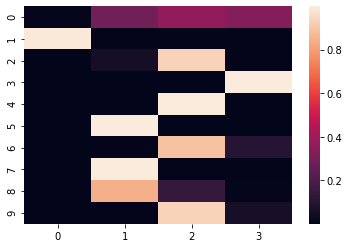

In [128]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. For some analyses, we may simply use the posterior themselves rather than the most probably code outcome.

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [129]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99,0.75,0.25])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

array([[0, 0, 1],
       [0, 0, 3],
       [0, 0, 3],
       [0, 1, 2],
       [1, 1, 0],
       [0, 0, 1],
       [0, 0, 3],
       [0, 3, 2],
       [3, 3, 2],
       [1, 1, 3],
       [3, 2, 2],
       [0, 0, 1],
       [1, 1, 2],
       [0, 3, 3],
       [3, 3, 2],
       [1, 1, 0],
       [0, 3, 0],
       [0, 0, 3],
       [0, 0, 2],
       [3, 3, 3]])

## Visualizing coder accuracy

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipython notebooks. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [130]:
model = ModelBt.create_initial_state(4, 8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

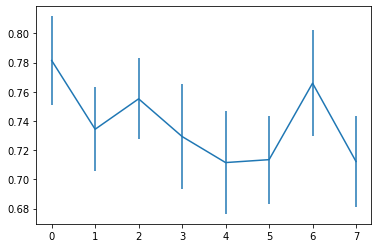

In [131]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Example with articles that use the General Social Survey

I performed a recent study in which the variables from thousands of articles were associated with those used in the General Social Survey, a widely used population sample, in order to interrogate how social science analyses are performed. Each article was reread and coded by a balanced set of three student coders using a 6 choose 3 design, such that all possible 3-coder-subsets (20) coded an equal number of articles. Coding was performed through a website that allowed students access to the digital article. To evaluate the validity of the student codes, we also recruited a sample of authors associated with 97 of our published articles to fill out the same online survey. 

Because not all coders coded items with equal accuracy, and because “don’t know” was an optional answer, leading to potential ties, we used a generative, probabilistic model to estimate the maximum a posteriori probability (MAP) prediction that an item’s code is true, which integrates over the estimated accuracy of coders, assuming only that the entire population of coders is slightly more often right than wrong. The model (“Model B”) is based on a simple underlying generation process that directly accounts for the probability that coded values are correct (Rzhetsky et al. 2009). For each coded value j, a set of parameters, denoted γj, represents the probability that each coded value is correct. For the ith coder (i = 1, 2, …, 6), we introduce a matrix of probabilities, denoted λ(i)x|y, that defines the probability that she assigns code x (e.g., Dependent variable) to a GSS variable with correct annotation y. For a perfect coder, the matrix λ(i)x|y would equal the identity matrix and her vote would count most toward the total. For a coder that always codes incorrectly—a “troll”—her matrix λ(i)x|y will have all its value off the diagonal and will only minimally influence the posterior. We co-authored the open source pyanno software that implements this model.

Getting the data for each content analysis survey regarding how GSS variables were used in a large population of social science articles.

In [132]:
#anno_vdep = AnnotationsContainer.from_file(missing_values=[-1], filename="GSSvariable_testSdependent.csv")
dev = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSdependent.csv", dtype=int, delimiter=",")
anno_dv = AnnotationsContainer.from_array(dev)

ind = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSindependent.csv", dtype=int, delimiter=",")
anno_iv = AnnotationsContainer.from_array(ind)

cent = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScentral.csv", dtype=int, delimiter=",")
anno_cv = AnnotationsContainer.from_array(cent)

cont = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScontrol.csv", dtype=int, delimiter=",")
anno_ctv = AnnotationsContainer.from_array(cont)

test = np.loadtxt(fname="../data/dataforgssstudy/testH.csv", dtype=int, delimiter=",")
anno_test = AnnotationsContainer.from_array(test)

Let's examine the data structure.

In [133]:
dev.shape

(21461, 6)

In [134]:
anno_dv.labels

[0, 1]

In [135]:
anno_dv.missing_values

[-1]

In [136]:
anno_dv.annotations.shape

(21461, 6)

First, let's use Cohen's $\kappa$ to measure agreement between coders...

In [137]:
m = pairwise_matrix(cohens_kappa, anno_dv.annotations)
print(m)

[[1.         0.62426874 0.46682841 0.44599604 0.16569888 0.36657805]
 [0.62426874 1.         0.53480937 0.52673854 0.3306905  0.59513211]
 [0.46682841 0.53480937 1.         0.50580068 0.42393752 0.49833997]
 [0.44599604 0.52673854 0.50580068 1.         0.46517493 0.47023754]
 [0.16569888 0.3306905  0.42393752 0.46517493 1.         0.66190749]
 [0.36657805 0.59513211 0.49833997 0.47023754 0.66190749 1.        ]]


Let's visualize that...

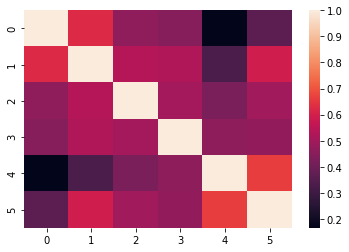

In [138]:
ax = seaborn.heatmap(m)
plt.show()

In [139]:
pairwise_metric_average(cohens_kappa, anno_dv.annotations)

0.4721425844540702

Let's compute the statistics on each of the datasets and with Pearson's $\rho$. 

In [140]:
datasets = [anno_dv.annotations, anno_iv.annotations, anno_cv.annotations, anno_ctv.annotations]
ck = [pairwise_matrix(cohens_kappa, anno) for anno in datasets]
pr = [pairwise_matrix(pearsons_rho, anno) for anno in datasets]
titles = ['DV', 'IV', 'Central Variable', "Control Variable"]

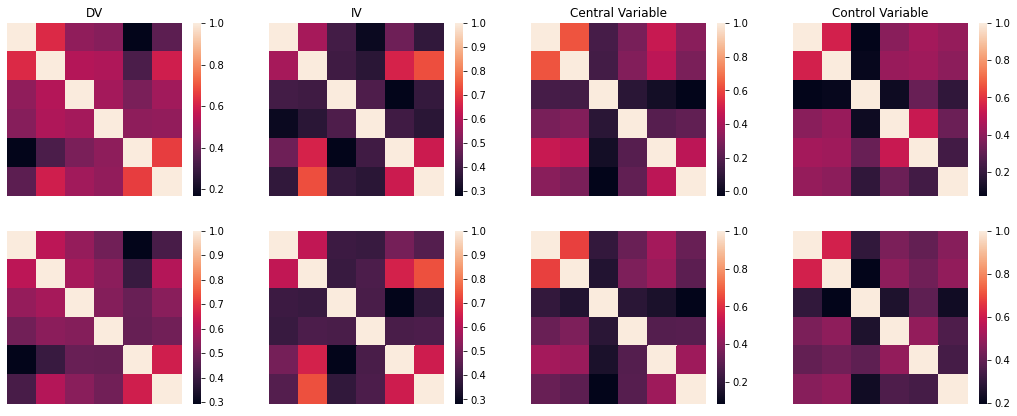

In [141]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18, 7)
for k, ax, title in zip(ck,axs[0], titles):
    seaborn.heatmap(k, ax = ax)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
for r, ax in zip(pr,axs[1]):
    seaborn.heatmap(r, ax = ax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

Now we will compare the student coders.

In [142]:
nondiag = (np.eye(6)-np.ones(6))*-1.0

In [143]:
xdevck = pairwise_matrix(cohens_kappa, anno_dv.annotations)
xdevpr = pairwise_matrix(pearsons_rho, anno_dv.annotations)

xindck = pairwise_matrix(cohens_kappa, anno_iv.annotations)
xindpr = pairwise_matrix(pearsons_rho, anno_iv.annotations)

xcenck = pairwise_matrix(cohens_kappa, anno_cv.annotations)
xcenpr = pairwise_matrix(pearsons_rho, anno_cv.annotations)

xconck = pairwise_matrix(cohens_kappa, anno_ctv.annotations)
xconpr = pairwise_matrix(pearsons_rho, anno_ctv.annotations)

print(np.average(xdevck, weights=nondiag))
print(np.average(xdevpr, weights=nondiag))
print(np.average(xindck, weights=nondiag))
print(np.average(xindpr, weights=nondiag))
print(np.average(xcenck, weights=nondiag))
print(np.average(xcenpr, weights=nondiag))
print(np.average(xconck, weights=nondiag))
print(np.average(xconpr, weights=nondiag))

0.47214258445407015
0.5142407278222343
0.4529627823703711
0.4759652686686345
0.27082376869768193
0.31514049828362717
0.32833477875850064
0.39458527791963477


Now we are going to bring in "gold standard" data. In this case, this is where we asked authors of the articles to code their own article's variables and compare with our student coders.

In [144]:
mergedata = np.loadtxt(fname="../data/dataforgssstudy/gss_mergedataC.txt", dtype=int, delimiter="\t")

In [145]:
anno_merge_dep = AnnotationsContainer.from_array(mergedata[:,0:2])
anno_merge_ind = AnnotationsContainer.from_array(mergedata[:,2:4])
anno_merge_cen = AnnotationsContainer.from_array(mergedata[:,4:6])
anno_merge_con = AnnotationsContainer.from_array(mergedata[:,6:8])
anno_merge_dkn = AnnotationsContainer.from_array(mergedata[:,8:10])

In [146]:
print("""Dependent variable -- kappa & rho""")
print(cohens_kappa(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))
print(pearsons_rho(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))

print("\nIndependent variable")
print(cohens_kappa(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))
print(pearsons_rho(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))

print("\nCentral variable")
print(cohens_kappa(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))
print(pearsons_rho(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))

print("\nControl variable")
print(cohens_kappa(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))
print(pearsons_rho(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))

Dependent variable -- kappa & rho
0.3744311057948666
0.38563437203620626

Independent variable
0.5430690164641346
0.5529974941771466

Central variable
-0.064017189548477
-0.08887644319259179

Control variable
0.2815172499181942
0.28239237574620263


Whoah! Student coders and authors viewed articles that were "central" or critical to the published argument as fundamentally different (exhibiting negative agreement and correlation). Why? Likely because that researchers recalled what they had _intended_ as their central variables before analysis, but those that _worked out_ became central in the text.

Now for the assessment of the relative values of authors, then student coders.

In [147]:
print("Dependent")
print(np.average(anno_merge_dep.annotations[:,0]))
print(np.average(anno_merge_dep.annotations[:,1]))

print("\nIndependent")
print(np.average(anno_merge_ind.annotations[:,0]))
print(np.average(anno_merge_ind.annotations[:,1]))

print("\nCentral")
print(np.average(anno_merge_cen.annotations[:,0]))
print(np.average(anno_merge_cen.annotations[:,1]))

print("\nControl")
print(np.average(anno_merge_con.annotations[:,0]))
print(np.average(anno_merge_con.annotations[:,1]))

Dependent
0.4763912310286678
0.35834738617200673

Independent
0.23777403035413153
0.3136593591905565

Central
0.35328836424957843
0.7512647554806071

Control
0.081787521079258
0.09443507588532883


## Now we are going to use models to predict the correct annotations

Recall that Model A is built for 8 coders, but we have 6. We're going to *hack* it by adding two blank columns.

In [148]:
dev.shape

(21461, 6)

In [149]:
negs2 = np.ones((21461, 2), dtype=np.int)*(-1)
devA = np.concatenate((dev, negs2), axis=1)
devA

array([[ 0, -1, -1, ...,  1, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [150]:
anno_dvA = AnnotationsContainer.from_array(devA)
model_devA = ModelA.create_initial_state(2)
model_devA.theta

array([0.86556843, 0.75453968, 0.7683175 , 0.80392942, 0.60183704,
       0.63951248, 0.70015919, 0.90635293])

In [151]:
model_dvB = ModelB.create_initial_state(2, 6)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[0.27812072 0.72187928]
-37975.565993237266


In [152]:
model_dvB.map(anno_dv.annotations)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[0.69455487 0.30544513]
-25462.473635032595


In [153]:
# compute the posterior distribution over true annotations
posterior_dvB = model_dvB.infer_labels(anno_dv.annotations)
# each row show the probability of each label class for the
# corresponding item
print(posterior)

[[0.01111055 0.28958414 0.36496873 0.33433658]
 [0.9902288  0.0024177  0.00404742 0.00330608]
 [0.00249947 0.05500297 0.9346722  0.00782537]
 ...
 [0.00252887 0.04388808 0.94566565 0.00791741]
 [0.00249395 0.00571    0.93261008 0.05918597]
 [0.03185979 0.93887121 0.01610989 0.01315912]]


In [154]:
samples_dvB = model_dvB.sample_posterior_over_accuracy(anno_dv.annotations, 200, burn_in_samples=100, thin_samples=3)

In [155]:
# we can then compute a credible interval for the parameters:
ci_dv_mean = samples_dvB[0].mean(axis=0)
print("Mean")
print(ci_dv_mean)

ci_dv_stdev = samples_dvB[0].std(axis=0)
print("\nSTD")
print(ci_dv_stdev)


Mean
[[[0.97886366 0.02113634]
  [0.5144123  0.4855877 ]]

 [[0.96887963 0.03112037]
  [0.25804587 0.74195413]]

 [[0.98261326 0.01738674]
  [0.34342889 0.65657111]]

 [[0.93438061 0.06561939]
  [0.23925381 0.76074619]]

 [[0.6914761  0.3085239 ]
  [0.04583306 0.95416694]]

 [[0.86249765 0.13750235]
  [0.06837033 0.93162967]]]

STD
[[[0.00224664 0.00224664]
  [0.01188577 0.01188577]]

 [[0.00315089 0.00315089]
  [0.01361171 0.01361171]]

 [[0.00326458 0.00326458]
  [0.0146957  0.0146957 ]]

 [[0.00514129 0.00514129]
  [0.01202299 0.01202299]]

 [[0.00723562 0.00723562]
  [0.0050601  0.0050601 ]]

 [[0.00724259 0.00724259]
  [0.0068329  0.0068329 ]]]


We will use Model B estimates for other variable assessments.

In [156]:
#test
model_testB = ModelB.create_initial_state(2, 6)
print(model_testB.log_likelihood(anno_test.annotations))
model_testB.map(anno_test.annotations)
print(model_testB.pi)
print(model_testB.log_likelihood(anno_test.annotations))
print(anno_test.annotations.shape)
posterior_testB = model_testB.infer_labels(anno_test.annotations)
print(posterior_testB.shape)
samples_testB = model_testB.sample_posterior_over_accuracy(anno_test.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_test_mean = samples_testB[0].mean(axis=0)
print(ci_test_mean)

-95.37853562453523
[9.20933481e-20 1.00000000e+00]
-48.9756711393957
(48, 6)
(48, 2)
[[[0.79743234 0.20256766]
  [0.12728208 0.87271792]]

 [[0.78800265 0.21199735]
  [0.09196925 0.90803075]]

 [[0.80409109 0.19590891]
  [0.50060959 0.49939041]]

 [[0.80060116 0.19939884]
  [0.07251262 0.92748738]]

 [[0.80782713 0.19217287]
  [0.36425982 0.63574018]]

 [[0.79377826 0.20622174]
  [0.12787796 0.87212204]]]


In [157]:
#indepedent variables
model_ivB = ModelB.create_initial_state(2, 6)
print(model_ivB.log_likelihood(anno_iv.annotations))
model_ivB.map(anno_iv.annotations)
print(model_ivB.pi)
print(model_ivB.log_likelihood(anno_iv.annotations))
print(anno_iv.annotations.shape)
posterior_ivB = model_ivB.infer_labels(anno_iv.annotations)
print(posterior_ivB.shape)
samples_ivB = model_ivB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_iv_mean = samples_ivB[0].mean(axis=0)
print(ci_iv_mean)

#central variables
model_cvB = ModelB.create_initial_state(2, 6)
print(model_cvB.log_likelihood(anno_cv.annotations))
model_cvB.map(anno_cv.annotations)
print(model_cvB.pi)
print(model_cvB.log_likelihood(anno_cv.annotations))
print(anno_cv.annotations.shape)
posterior_cvB = model_cvB.infer_labels(anno_cv.annotations)
print(posterior_cvB.shape)
samples_cvB = model_cvB.sample_posterior_over_accuracy(anno_cv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_cv_mean = samples_cvB[0].mean(axis=0)
print(ci_cv_mean)

#control variables
model_ctvB = ModelB.create_initial_state(2, 6)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
model_ctvB.map(anno_ctv.annotations)
print(model_ctvB.pi)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
print(anno_ctv.annotations.shape)
posterior_ctvB = model_ctvB.infer_labels(anno_ctv.annotations)
print(posterior_ctvB.shape)
samples_ctvB = model_ctvB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_ctv_mean = samples_ctvB[0].mean(axis=0)
print(ci_ctv_mean)

-43056.85460062002
[0.61093546 0.38906454]
-28620.66523246587
(21461, 6)
(21461, 2)
[[[0.97156161 0.02843839]
  [0.34664562 0.65335438]]

 [[0.93654246 0.06345754]
  [0.05303775 0.94696225]]

 [[0.65843085 0.34156915]
  [0.21030353 0.78969647]]

 [[0.53609572 0.46390428]
  [0.03035856 0.96964144]]

 [[0.8745799  0.1254201 ]
  [0.09701822 0.90298178]]

 [[0.89048605 0.10951395]
  [0.08921949 0.91078051]]]
-53132.92994618039
[0.23988844 0.76011156]
-25034.918555765576
(21461, 6)
(21461, 2)
[[[0.90174762 0.09825238]
  [0.07132161 0.92867839]]

 [[0.79359196 0.20640804]
  [0.05903497 0.94096503]]

 [[0.99237139 0.00762861]
  [0.84292878 0.15707122]]

 [[0.95249667 0.04750333]
  [0.45764388 0.54235612]]

 [[0.68284608 0.31715392]
  [0.05892995 0.94107005]]

 [[0.5963692  0.4036308 ]
  [0.09717092 0.90282908]]]
-22014.22259925383
[0.83068326 0.16931674]
-19415.702035242168
(21461, 6)
(21461, 2)
[[[0.97099932 0.02900068]
  [0.34694652 0.65305348]]

 [[0.93652399 0.06347601]
  [0.05371337 0.94

Now we will package up the predicted data into a format we can use for other, subsequent analysis:

In [158]:
print(posterior_dvB.shape)
print(posterior_ivB.shape)
print(posterior_cvB.shape)
print(posterior_ctvB.shape)

(21461, 2)
(21461, 2)
(21461, 2)
(21461, 2)


In [159]:
predicted_annotations = np.concatenate((posterior_dvB, posterior_ivB, posterior_cvB, posterior_ctvB), axis=1) # posterior_dvBt, posterior_ivBt, posterior_cvBt, posterior_ctvBt), axis=1)

In [160]:
predicted_annotations.shape

(21461, 8)

These annotations allowed us to uncover the degree to which social scientists alter their models to achieve a better fit...undocumented data mining. The answer was that social scientists did mine their data, but that it likely improved their analysis because change in the social world was the result of greater distortion than undocumented data mining.

## Another example analysis looks at a different data set of Hotel Reviews by a variety of patrons.

In [161]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [162]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

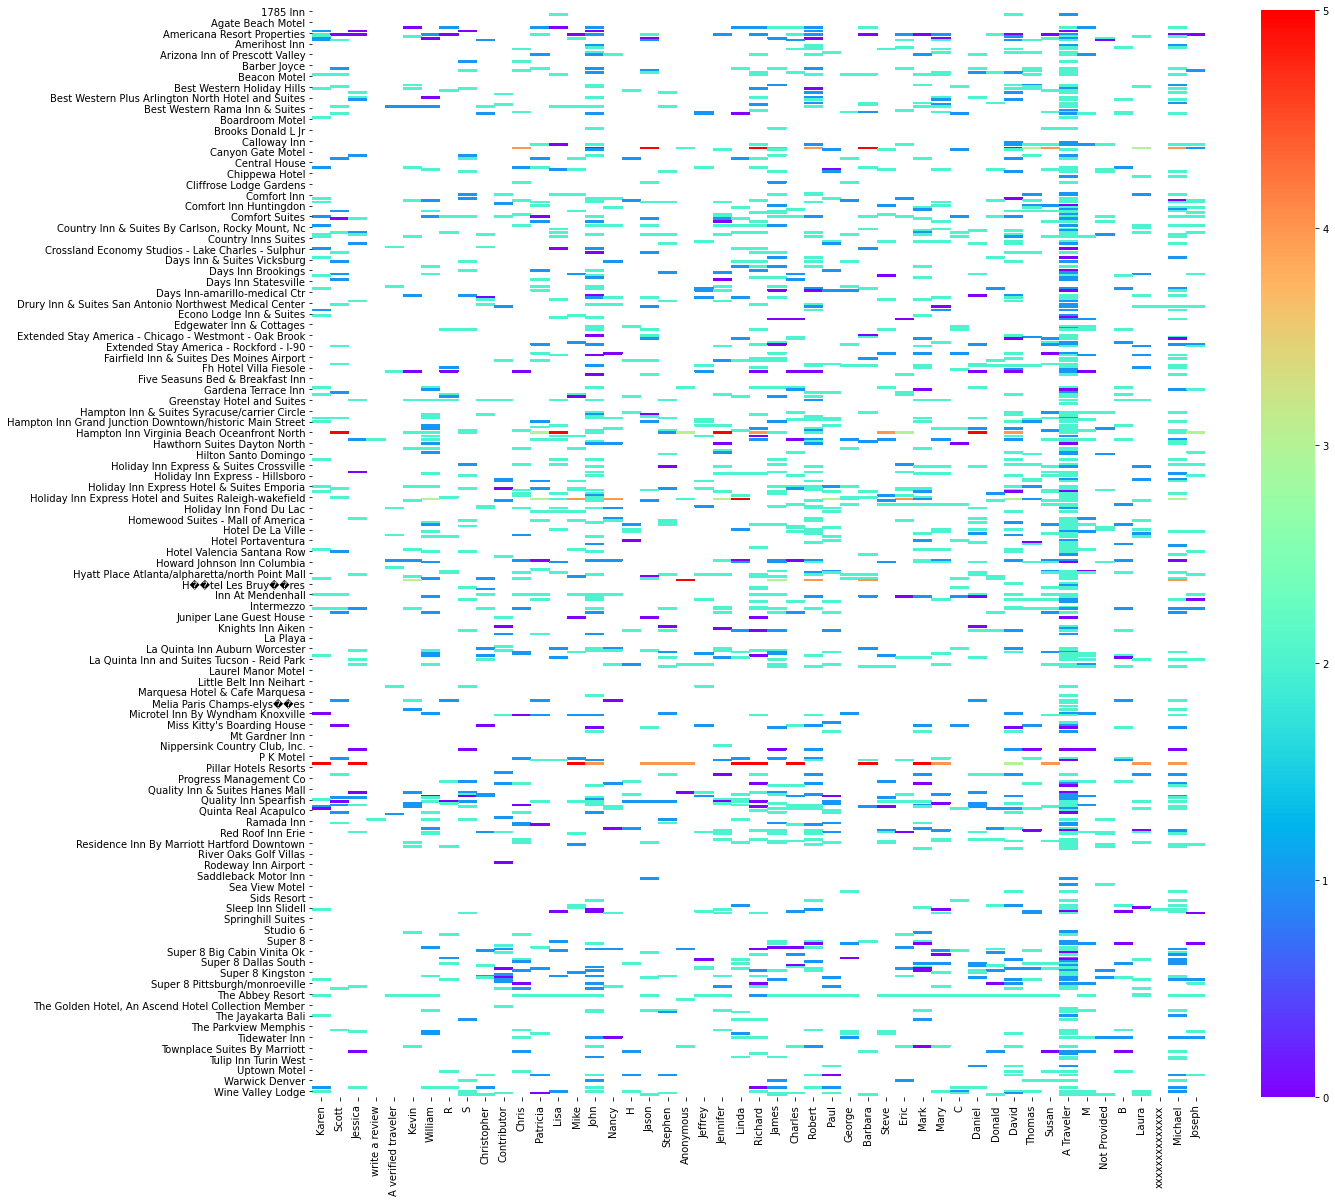

In [163]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [165]:
hot_mat = np.array(df_hotels.fillna(-1))
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [166]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [167]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [168]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [169]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


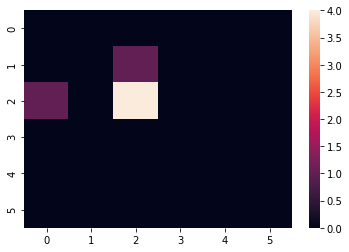

In [170]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [171]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [172]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [173]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


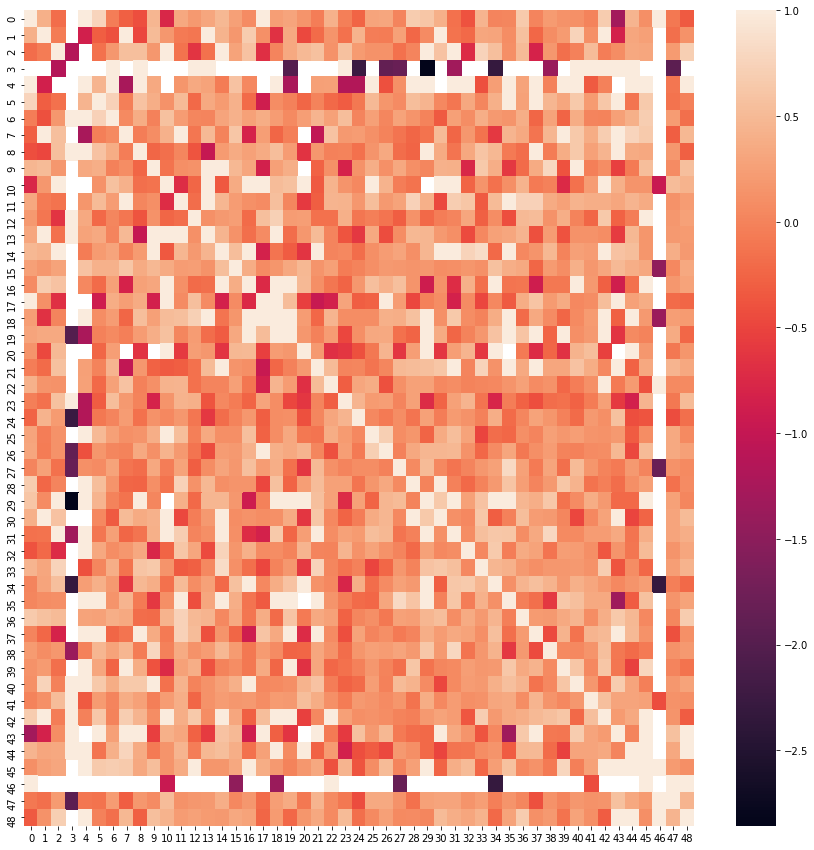

In [174]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

In [175]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

[0.79045059 0.73958411 0.76124448 0.72412395 0.71536355 0.71731771
 0.77235659 0.7154689 ]
-2702.8309175046616


In [176]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<Figure size 1080x720 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a4eb57a90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a4ebced68>))

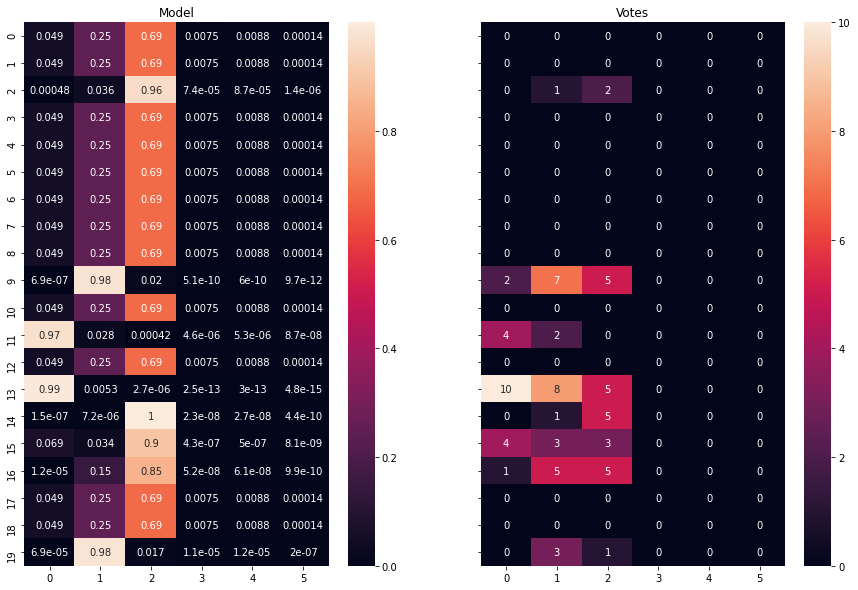

In [177]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

I first use MAP and MLE estimates from Model Bt to predict high and low-quality analysts

In [182]:
model = ModelBt.create_initial_state(2, 16)
model.map(anno_d.annotations)
samples = model.sample_posterior_over_accuracy(anno_d.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

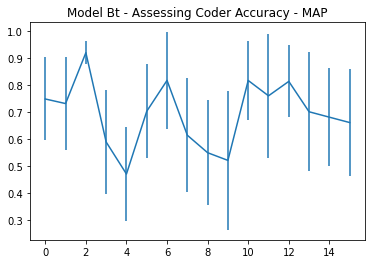

In [187]:
plt.figure()
plt.errorbar(range(16),y, yerr = y_ci)
plt.title('Model Bt - Assessing Coder Accuracy - MAP')
plt.show()

In [186]:
model = ModelBt.create_initial_state(2, 16)
model.mle(anno_d.annotations)
samples = model.sample_posterior_over_accuracy(anno_d.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

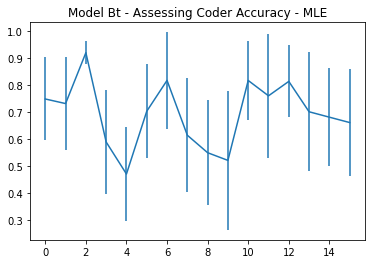

In [188]:
plt.figure()
plt.errorbar(range(16),y, yerr = y_ci)
plt.title('Model Bt - Assessing Coder Accuracy - MLE')
plt.show()

Both plots look quite similar, and it looks like Coder 3 was the most accurate. However, most of the estimates have very large confidence intervals because of the small sample size per coder so it is difficult to be conclusive about coder accuracy

Next I use Models B and Bt to predict MAP estimates for my codes.

Both models give similar results, and the estimates are not that different from taking a majority vote amongst the coders. This is probably because, as we see above, there actually isn't significant variation in coder accuracy when we account for the large confidence intervals. If that is the case and we give each coder roughly equal weight, we will see that the MAP estimates don't differ vastly from taking coder results at face value

In [178]:
# create a new instance of model B, with 2 label classes and 16 annotators
model = ModelB.create_initial_state(2, 16)
model.map(anno_d.annotations)

votes = []
for r in anno_d.annotations:
    v = [0] * len(anno_d.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

posterior = model.infer_labels(anno_d.annotations)

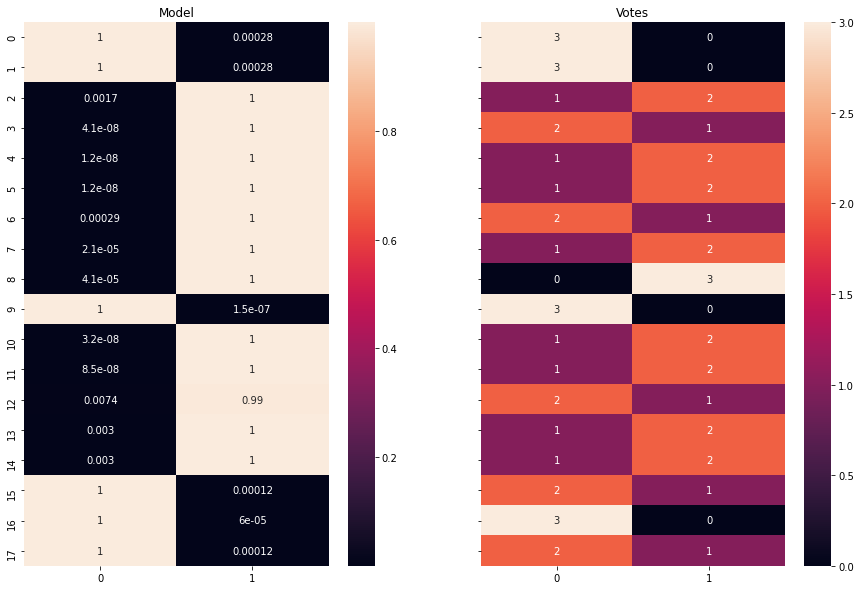

In [189]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
seaborn.heatmap(votes_array, annot = True, ax=ax2)
seaborn.heatmap(posterior, annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

In [190]:
# create a new instance of model B, with 2 label classes and 16 annotators
model = ModelBt.create_initial_state(2, 16)
model.map(anno_d.annotations)

votes = []
for r in anno_d.annotations:
    v = [0] * len(anno_d.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

posterior = model.infer_labels(anno_d.annotations)

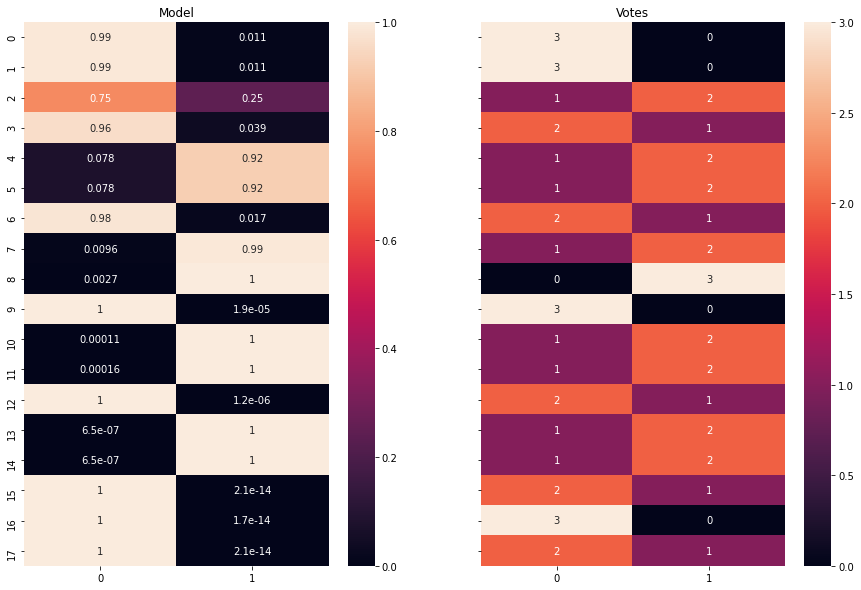

In [191]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

seaborn.heatmap(votes_array, annot = True, ax=ax2)
seaborn.heatmap(posterior, annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()